In [1]:
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, variance, stdev
from scipy.stats import binom
from collections import Counter
from itertools import chain
from matplotlib import animation
from matplotlib import rcParams
rcParams['animation.embed_limit'] = 1000 #MB
from IPython.display import HTML
from multiprocessing import Pool



In [31]:
# ------------------------------------------------------------------------------------------
START_POP = 200
MAX_POP = 1000
MIN_POP = 200
STEP_POP = 200
WAIT_POP = 5

GENOME_LENGTH = 5
MUTATION_RATE = 1/(2*GENOME_LENGTH) #per site rate
GENERATIONS = 3000
TSIZE = -1.3 #negative sets roulette exponent
# ------------------------------------------------------------------------------------------

In [32]:
DR = {}
ER = {}
def getDriftReference(initialPop,finalPop):
    key = (initialPop,finalPop)
    if key not in DR:
        DR[key] = [binom.pmf(x, finalPop, 1/initialPop) for x in range(finalPop+1)]
    return DR[key]

def getEliteReference(initialPop,finalPop):
    key = (initialPop,finalPop)
    if key not in ER:
        ER[key] = [initialPop-1]+[0 for _ in range(finalPop-1)]+[1]
    return ER[key]

list(map(round,np.multiply(5,getDriftReference(5,5))))

[2, 2, 1, 0, 0, 0]

In [33]:
class Organism:
    def __init__(self,startingFitness = None):
        global GENOME_LENGTH
        self.genome = [random.randint(0,1) for _ in range(GENOME_LENGTH)]
        self.offspringCount = 0
        self.fitness = startingFitness
        
    def make_mutated_copy(self):
        global GENOME_LENGTH, MUTATION_RATE
        self.offspringCount += 1
        child = Organism()
        child.genome = copy.deepcopy(self.genome)
        for i in range(GENOME_LENGTH):
            if random.random() <= MUTATION_RATE:
                PN = random.randint(0,1)
                child.genome[i] += (-1*PN)+(1-PN)
        return child
    
    def __repr__(self,):
        return str(self.fitness)


def fitness(org):
    if not org.fitness:
        org.fitness = 1
#         org.fitness = eval_sawTooth(sum(org.genome))
#         org.fitness = max( sum(org.genome), 0)
    return org.fitness


def eval_sawTooth(x):
#     x = org.genomeValue #0 is top of first peak
    w = 6 #valley width
    d = 10 #valley depth
    r = 10 #fitness rise peak to peak
    x = x + w+1 #offset to next peak to avoid fitness zero on init
    return x*(-d/w) + (x//(w+1))*(r + d + (d/w)) 

def roulette_select(population,batchSize,exponent=1.05):
    MAX = max([fitness(x) for x in population])
    F = [np.power(exponent,fitness(x)-MAX) for x in population]
    S = sum(F)
    return random.choices(population,k=batchSize,weights=[f/S for f in F])


def tournament_select(population,size=2):
    return max(random.choices(population, k=size),key= lambda x: fitness(x))


def emd(P,Q):
    assert len(P) == len(Q)
    EMD = [0]
    for i in range(len(P)):
        EMD.append(P[i]-Q[i]+EMD[-1])
    return sum([abs(d) for d in EMD])


# def getSS(offCounts_1d,initialPop,finalPop):
#     Counts = Counter(offCounts_1d)
# #     largest = sorted(Counts.items())[-1][0]
#     Observed = [Counts[x]/initialPop if x in Counts else 0 for x in range(finalPop+1)]
#     return (emd(getDriftReference(initialPop,finalPop),Observed),
#             emd(getEliteReference(initialPop,finalPop),Observed))

def getSS(offCounts_1d):
    Counts = Counter(offCounts_1d)
    N_init = int(sum(Counts.values()))
    N_final = sum([int(k)*int(v) for k,v in Counts.items()])
    Observed = [Counts[x]/N_init if x in Counts else 0 for x in range(N_final+1)]
    return (emd(getDriftReference(N_init,N_final),Observed), emd(getEliteReference(N_init,N_final),Observed))

In [34]:
def newPopulation(population,popSize,tournament = 0):
    
    if tournament < 0:
        #do roulette
        new_pop = [parent.make_mutated_copy() for parent in
                   roulette_select(population,popSize,exponent=-tournament)]
    elif tournament >= 1:
        #do tournament
        new_pop = [tournament_select(population,size=tournament).make_mutated_copy() for _ in range(popSize)]
    else:
        print("invalid selection strength parameter",tournament)
        exit(1)
        
    return new_pop, [org.offspringCount for org in population]
    

def run():
    newPopSize = START_POP
    popIncrease = True
    popWait = 0
    
    population = [Organism() for _ in range(newPopSize)]
    offCounts = []
    fitnessLog = []
    popSizeLog = []
    popChangeColor = []
    phenotypeLog = []
    for generation in range(GENERATIONS):
        print(100*generation/GENERATIONS,end="\r")
        
        fitnessLog.append([fitness(org) for org in population])

        phenotypeLog.append([sum(org.genome) for org in population])
        

        
        popSizeLog.append((len(population),newPopSize))
        

        
        if len(population) != newPopSize:
            popChangeColor.append((-1*int(not popIncrease) + int(popIncrease)))
        else:
            popChangeColor.append(0)
            
        population, offspringCounts = newPopulation(population,newPopSize,tournament=TSIZE)

        offCounts.append(offspringCounts)
        
        if newPopSize >= MAX_POP: popIncrease = False
        if newPopSize <= MIN_POP: popIncrease = True
        
        popWait += 1
        if popWait == WAIT_POP:
            popWait = 0
            newPopSize += STEP_POP * (-1*int(not popIncrease) + int(popIncrease))

    return fitnessLog, offCounts, popSizeLog, popChangeColor, phenotypeLog


In [35]:
random.seed(6)

fitnessLog, offCounts, PSlog, PClog, phenotypeLog = run()



In [37]:
# for offCount in offCounts:
#     counts = Counter(offCount)
#     N_init = sum(counts.values())
#     N_final = sum([k*v for k,v in counts.items()])
#     print(N_init,N_final)
#     Observed = [counts[x]/N_init if x in counts else 0 for x in range(N_final+1)][:max(counts.keys())+1]
#     reference = getDriftReference(N_init,N_final)[:max(counts.keys())+1]
#     plt.plot(Observed,marker="o",linestyle="--")
#     plt.plot(reference,label="{}->{}".format(N_init,N_final))
#     plt.yscale("log")
#     plt.legend()
#     plt.show()
    

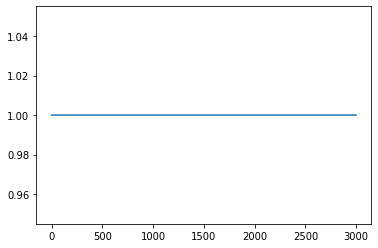

In [38]:
PSlog_T = list(zip(*PSlog))
initialPopSizes = PSlog_T[0]
finalPopSizes = PSlog_T[1]

with Pool(16) as MPPOOL:
#     SSdata = MPPOOL.starmap(getSS,zip(offCounts,initialPopSizes,finalPopSizes))
    SSdata = MPPOOL.map(getSS,offCounts)
    AVEdata = MPPOOL.map(mean,fitnessLog)
    VARdata = MPPOOL.map(variance,fitnessLog)

driftDists = list(zip(*SSdata))[0]
eliteDists = list(zip(*SSdata))[1]

plt.plot(AVEdata)
plt.show()

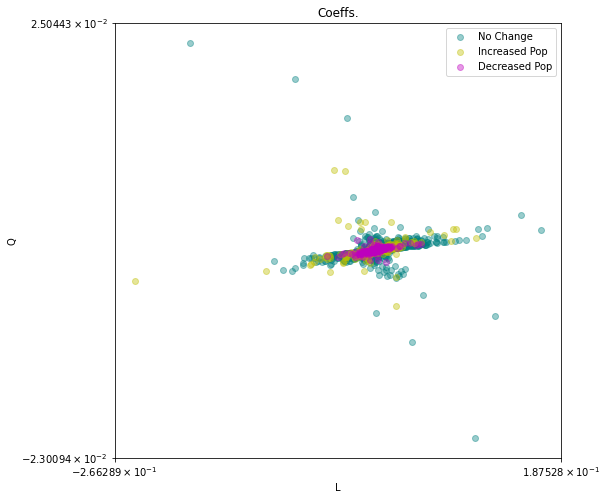

In [39]:
def specialPlot(X,SSMEASURE,title,xlabel,ylabel,save=False):
    global PClog
    INC = list(zip(*[(ps,ss) for ps,ss,clr in zip(X,SSMEASURE,PClog) if clr == 1]))
    DEC = list(zip(*[(ps,ss) for ps,ss,clr in zip(X,SSMEASURE,PClog) if clr == -1]))
    if not DEC: DEC=[(None),(None)]
    NOC = list(zip(*[(ps,ss) for ps,ss,clr in zip(X,SSMEASURE,PClog) if clr == 0]))

    plt.figure(figsize=(8,8))
    plt.scatter(NOC[0], NOC[1],c="teal",alpha=0.4,label="No Change")
    plt.scatter(INC[0], INC[1],c="y",alpha=0.4,label="Increased Pop")
    plt.scatter(DEC[0], DEC[1],c="m",alpha=0.4,label="Decreased Pop")
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xscale("symlog")
    plt.yscale("symlog")
    if save:
        plt.savefig("{}.png".format(title.replace("/","÷")))
    plt.show()
    
def polyfit(x, y, degree):
    results = {}
    coeffs = np.polyfit(x, y, degree)
    results['coeffs'] = coeffs
    p = np.poly1d(coeffs)
    results['model'] = p
    #calculate r-squared
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    results['r_squared'] = ssreg / sstot

    return results



# INDEX = 4

# results = polyfit(phenotypeLog[INDEX],offCounts[INDEX],2)
# print("Q",results['coeffs'])
# print(results["model"])

# lineX = np.linspace(min(phenotypeLog[INDEX]), max(phenotypeLog[INDEX]), 50)
# plt.scatter(phenotypeLog[INDEX], offCounts[INDEX],c="k")
# plt.plot(lineX, results['model'](lineX),c="r")
# plt.show()

Q,L = list(zip(*[polyfit(phenotypeLog[INDEX],offCounts[INDEX],2)["coeffs"][:2] for INDEX in range(GENERATIONS)]))
specialPlot(L,Q,"Coeffs.","L","Q",save=False)

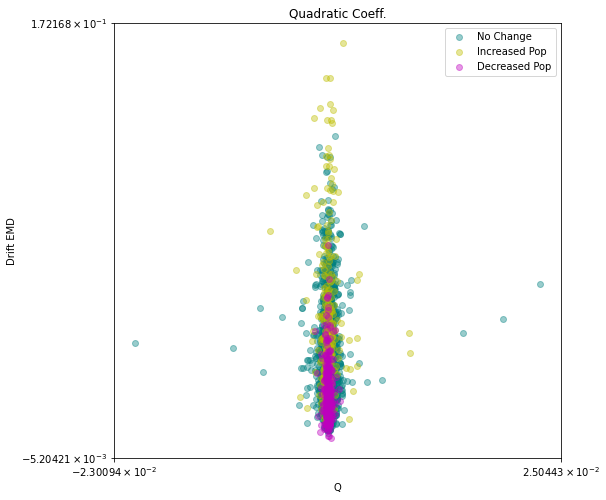

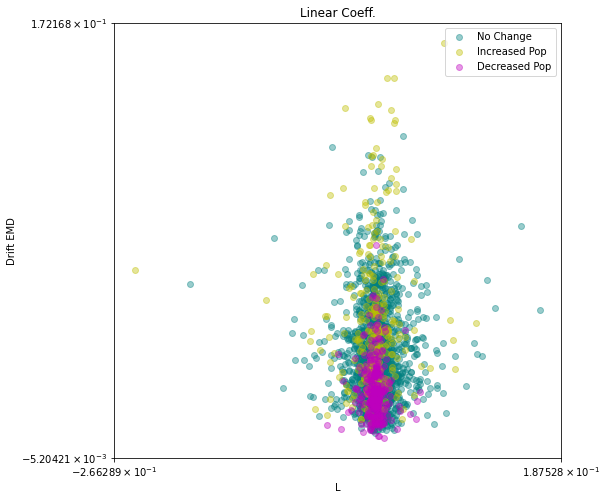

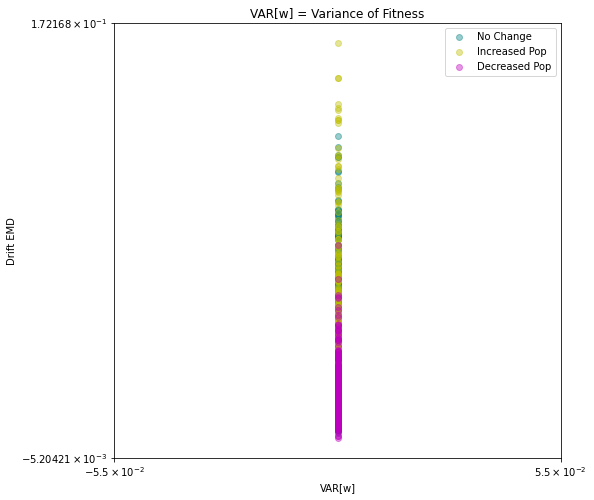

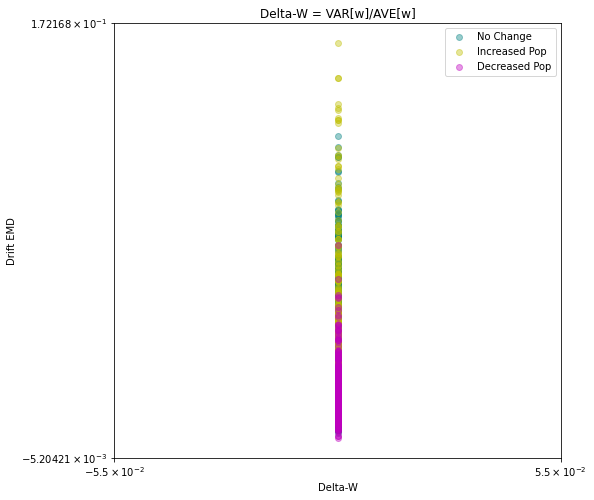

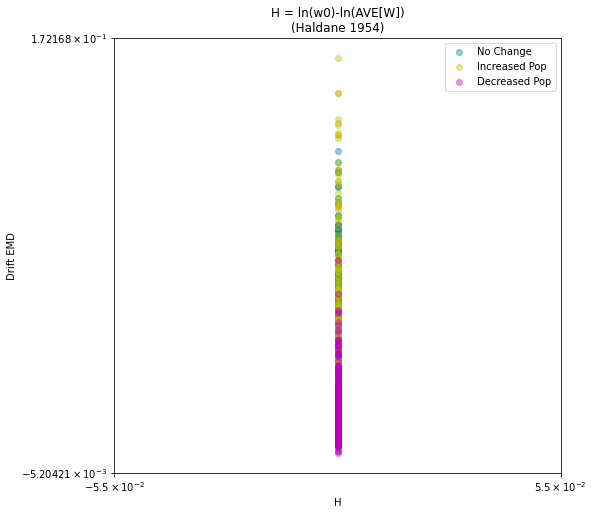

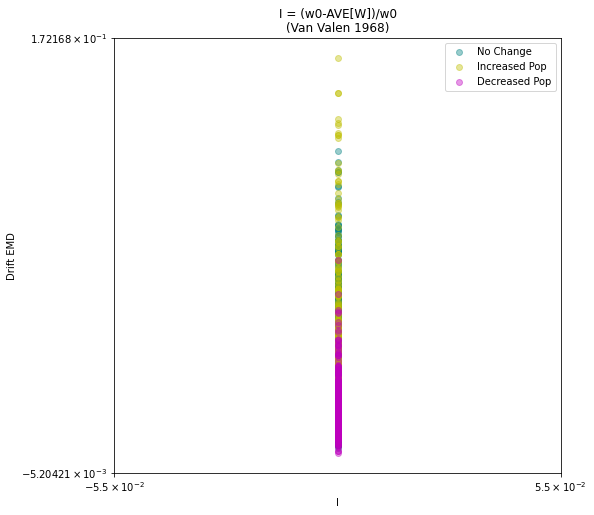

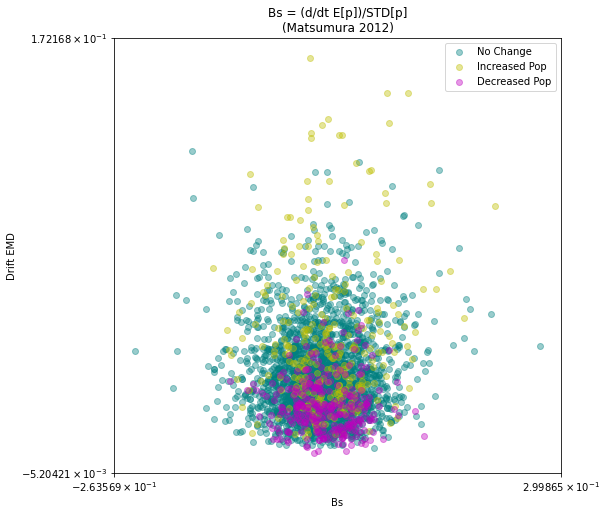

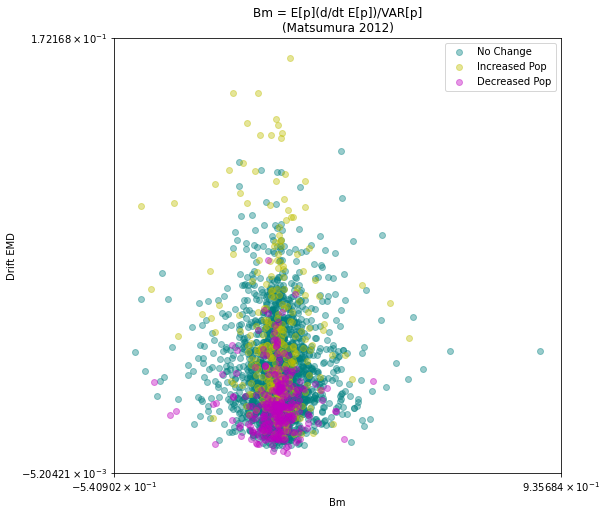

In [40]:
#self
SAVE = False


specialPlot(Q,driftDists,"Quadratic Coeff.","Q","Drift EMD",save=SAVE)
specialPlot(L,driftDists,"Linear Coeff.","L","Drift EMD",save=SAVE)
specialPlot(VARdata,driftDists,"VAR[w] = Variance of Fitness","VAR[w]","Drift EMD",save=SAVE)


DeltaW = np.divide(VARdata,AVEdata)
specialPlot(DeltaW,driftDists,"Delta-W = VAR[w]/AVE[w]","Delta-W","Drift EMD",save=SAVE)

#Haldane 1954
def Haldane(fitLog):
    MAX = max(fitLog)
    F = [np.power(-TSIZE,f-MAX) for f in fitnessLog[i]]
    S = sum(F)
    Ws = [f/S for f in F]
    W0 = max(Ws)
    Wbar = mean(Ws)
    Haldane.append( np.log(W0)-np.log(Wbar) )

Haldane = []
#Van Valen 1965
VanValen=[]

for i in range(len(fitnessLog)):
    MAX = max(fitnessLog[i])
    F = [np.power(-TSIZE,f-MAX) for f in fitnessLog[i]]
    S = sum(F)
    Ws = [f/S for f in F]
    W0 = max(Ws)
    Wbar = mean(Ws)
    Haldane.append( np.log(W0)-np.log(Wbar) )
    VanValen.append( (W0-Wbar)/W0 )

specialPlot(Haldane,driftDists,"H = ln(w0)-ln(AVE[W])\n(Haldane 1954)","H","Drift EMD",save=SAVE)
specialPlot(VanValen,driftDists,"I = (w0-AVE[W])/w0\n(Van Valen 1968)","I","Drift EMD",save=SAVE)


#matsumura 2012
beta_sigma = [0] + [ (mean(phenotypeLog[i+1])-mean(phenotypeLog[i]))/stdev(phenotypeLog[i]) 
                    for i in range(GENERATIONS-1)]
beta_mu = [0] + [ mean(phenotypeLog[i])*(mean(phenotypeLog[i+1])-mean(phenotypeLog[i]))/variance(phenotypeLog[i]) 
                    for i in range(GENERATIONS-1)]

specialPlot(beta_sigma,driftDists,"Bs = (d/dt E[p])/STD[p]\n(Matsumura 2012)","Bs","Drift EMD",save=SAVE)
specialPlot(beta_mu,driftDists,"Bm = E[p](d/dt E[p])/VAR[p]\n(Matsumura 2012)","Bm","Drift EMD",save=SAVE)

In [41]:
# specialPlot(initialPopSizes,driftDists)
# specialPlot(finalPopSizes,driftDists)

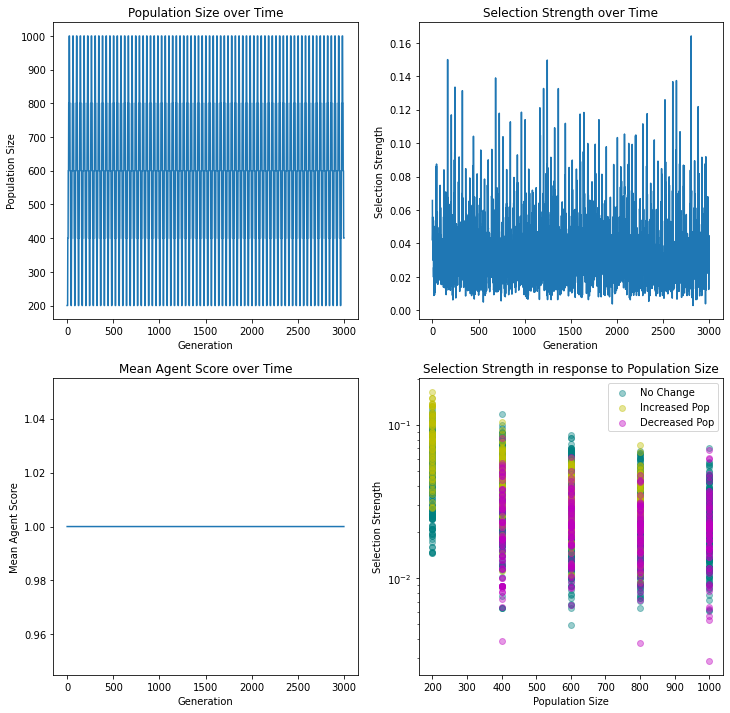

In [42]:
fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(2, 2)

ax2 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.set_title("Selection Strength over Time")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Selection Strength")
ax1.plot(driftDists)
# ax1.set_yscale("log")
# plt.show()

ax2.set_title("Population Size over Time")
ax2.set_xlabel("Generation")
ax2.set_ylabel("Population Size")
ax2.plot(initialPopSizes)
# plt.show()

ax3.set_title("Selection Strength in response to Population Size")
ax3.set_xlabel("Population Size")
ax3.set_ylabel("Selection Strength")

INC = list(zip(*[(ps,ss) for ps,ss,clr in zip(initialPopSizes,driftDists,PClog) if clr == 1]))
DEC = list(zip(*[(ps,ss) for ps,ss,clr in zip(initialPopSizes,driftDists,PClog) if clr == -1]))
if not DEC: DEC=[(None),(None)]
NOC = list(zip(*[(ps,ss) for ps,ss,clr in zip(initialPopSizes,driftDists,PClog) if clr == 0]))


ax3.scatter(NOC[0], NOC[1],c="teal",alpha=0.4,label="No Change")
ax3.scatter(INC[0], INC[1],c="y",alpha=0.4,label="Increased Pop")
ax3.scatter(DEC[0], DEC[1],c="m",alpha=0.4,label="Decreased Pop")

# ax3.set_xscale("log")
ax3.set_yscale("log")

ax4.set_title("Mean Agent Score over Time")
ax4.set_xlabel("Generation")
ax4.set_ylabel("Mean Agent Score")
ax4.plot(AVEdata)

plt.legend()
plt.show()

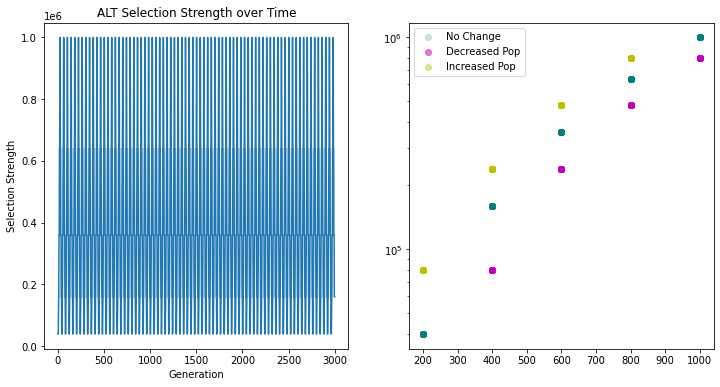

In [43]:
fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.set_title("ALT Selection Strength over Time")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Selection Strength")
ax1.plot(eliteDists)
# ax1.set_yscale("log")
# plt.show()

ax3.set_title("Selection Strength in response to Population Size")
ax3.set_xlabel("Population Size")
ax3.set_ylabel("Selection Strength")

INC = list(zip(*[(ps,ss) for ps,ss,clr in zip(initialPopSizes,eliteDists,PClog) if clr == 1]))
DEC = list(zip(*[(ps,ss) for ps,ss,clr in zip(initialPopSizes,eliteDists,PClog) if clr == -1]))
if not DEC: DEC=[(None),(None)]
NOC = list(zip(*[(ps,ss) for ps,ss,clr in zip(initialPopSizes,eliteDists,PClog) if clr == 0]))

ax2.scatter(NOC[0], NOC[1],c="teal",alpha=0.2,label="No Change")
ax2.scatter(DEC[0], DEC[1],c="m",alpha=0.5,label="Decreased Pop")
ax2.scatter(INC[0], INC[1],c="y",alpha=0.4,label="Increased Pop")
# ax2.set_xscale("log")
ax2.set_yscale("log")


plt.legend()
plt.show()

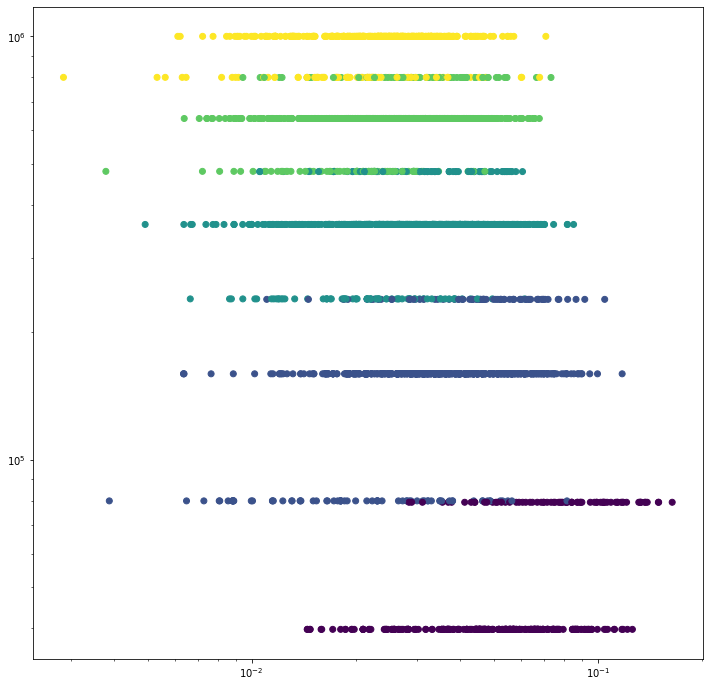

In [44]:
plt.figure(figsize=(12,12))
plt.scatter(driftDists,eliteDists,c=initialPopSizes)
plt.xscale("log")
plt.yscale("log")

In [45]:
fakeOffCounts = [[0,1,0,4,2,0,0,1],[3,0,0,0,0,3,2,0]]
fakeinitialPopSizes = [8,8]
fakefinalPopSizes = [8,8]

with Pool(16) as MPPOOL:
    SSdata = MPPOOL.map(getSS,fakeOffCounts)
    
print(SSdata)
print(mean(list(zip(*SSdata))[0]))

[(0.34280991554260254, 56.0), (0.5879151821136476, 56.0)]
0.46536254882812506


In [46]:
fakeOffCounts = [[0,1,0,4,2,0,0,1,3,0,0,0,0,3,2,0]]
fakeinitialPopSizes = [16]
fakefinalPopSizes = [16]

with Pool(16) as MPPOOL:
    SSdata = MPPOOL.map(getSS,fakeOffCounts)
    
print(SSdata)

[(0.4181078888196862, 240.0)]


In [47]:
fakeOffCounts = [[0,3,0,0,5,0,0,0]]
fakeinitialPopSizes = [8]
fakefinalPopSizes = [8]

with Pool(16) as MPPOOL:
    SSdata = MPPOOL.map(getSS,fakeOffCounts)
    
print(list(map( lambda x: x/2, list(zip(*SSdata))[0])))

[0.42017489671707153]
